<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [56]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
import plot_functions.plot_settings

# Constraints, periodic boundary conditions, static condensation -- FDM

PDE

$$
    0 = \frac{\partial c}{\partial t} + v \frac{\partial c}{\partial x}
$$

FDM

$$
    0 = \frac{c_i - c_i^n}{\Delta t} + v \frac{c_i - c_{i-1}}{\Delta x}
$$

Matrix

$$
    c_i^n = \left[\delta_{ij} + \frac{v \Delta t}{\Delta x}(\delta_{ij} - \delta_{i(j-1)}) \right] c_j
$$

In [57]:
L = 1.
number_of_points = 1000
dx = L/(number_of_points - 1)
x = np.linspace(0,L,number_of_points)

The right-hand side is identical in every point, unless the stiffness or the specific weight changes with depth.

In [58]:
v = 1
dt = dx/np.abs(v)

In [59]:
c0 = np.copy(x)*0.
c0[np.where(np.abs(x-L/2)<L/6)] = 1.

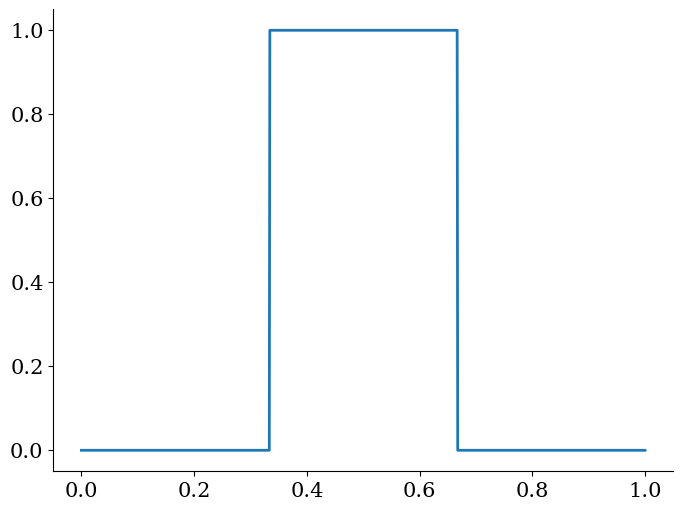

In [60]:
plt.plot(x,c0)

In [61]:
I = np.identity(len(x))
int(np.sign(v))

1

In [62]:
A = I + v*dt/dx*(I-np.diag([1]*(len(x)-1),-1))

In [63]:
Ainv = np.linalg.inv(A)

In [64]:
def operate(n,alpha=0.5):
    cn = np.copy(c0)
    for i in range(n):
        cimp = Ainv@cn
        cexp = cn - (A-I).dot(cn) 
        cn = alpha*cimp + (1-alpha)*cexp
    return cn

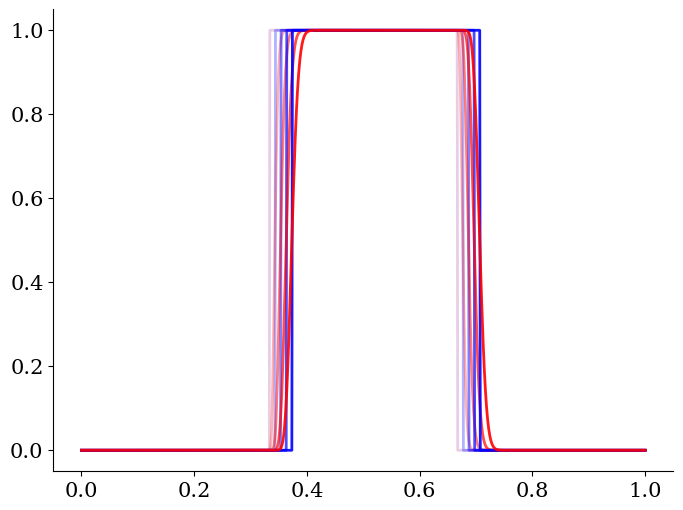

In [65]:
for i in range(0,50,10):
    plt.plot(x,operate(i,0),color='b',alpha=(i/50)+.1,label='explicit')
    plt.plot(x,operate(i,1),color='r',alpha=(i/50)+.1,label='implicit')

#plt.plot(x,operate(40))
#plt.plot(x,operate(40,0))

Periodic bc is added by introducing neighbourhood directly for backward difference.

In [66]:
def operate_pbc(n,alpha=0.5):
    K_pbc=np.copy(A)
    K_pbc[0,-1] = K_pbc[1,0]
    K_pbc_inv = np.linalg.inv(K_pbc)
    cn = np.copy(c0)
    cn[-1] = 0.
    for i in range(n):
        cn = K_pbc_inv@cn
        #cexp = cn - (A-I).dot(cn) 
        #cn = alpha*cimp + (1-alpha)*cexp
    return cn

Now with Lagrange multiplier ...

In [67]:
def operate_pbc_lagr(n,lagr=1):
    C = np.array(np.zeros((1,len(x))))
    C[0,0] = lagr
    C[0,-1] = -lagr
    d = np.array([0])
    zero_block = np.zeros((C.shape[0], C.shape[0]))
    K_pbc = np.block([[A , C.T],[C, zero_block]])
    K_pbc_inv = np.linalg.inv(K_pbc)
    cn = np.append(np.copy(c0),0)
    for i in range(n):
        cn = K_pbc_inv@cn
    return cn

Now with Least Squares

In [68]:
def operate_pbc_ls(n,mult=1):
    C = np.array(np.zeros((1,len(x))))
    C[0,0] = mult
    C[0,-1] = -mult
    d = np.array([0])
    K_pbc = np.block([[A],[C]])
    K_pbc_inv = np.linalg.inv(np.dot(K_pbc.T,K_pbc))
    cn = np.copy(c0)
    for i in range(n):
        cn = K_pbc_inv@(K_pbc.T@(np.append(cn,0)))
    return cn

(0.0, 1.0)

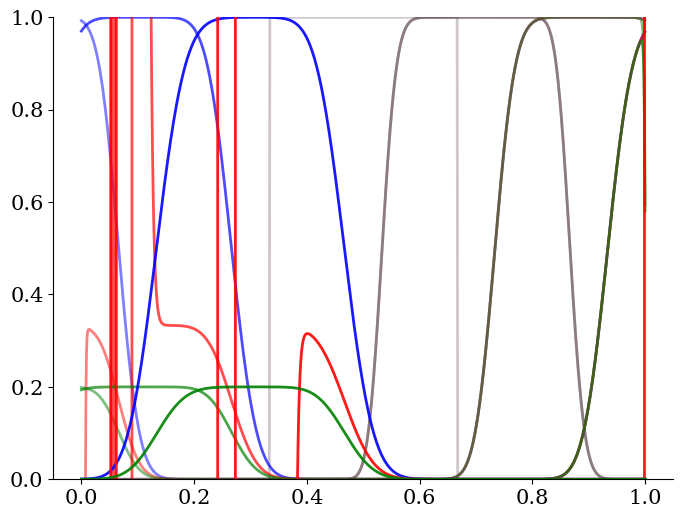

In [69]:
for i in range(0,1000,200):
    plt.plot(x,operate_pbc(i),color='b',alpha=(i/1000)+0.1)
    plt.plot(x,operate_pbc_lagr(i)[0:-1],color='r',alpha=(i/1000)+0.1)
    plt.plot(x,operate_pbc_ls(i),color='g',alpha=(i/1000)+0.1)
plt.ylim(0,1)


(0.0, 1.0)

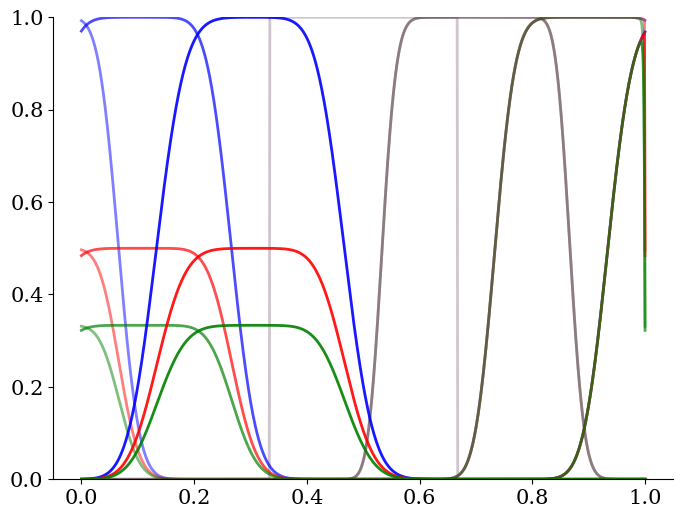

In [70]:
for i in range(0,1000,200):
    plt.plot(x,operate_pbc(i),color='b',alpha=(i/1000)+0.1)
    plt.plot(x,operate_pbc_lagr(i,1e3)[0:-1],color='r',alpha=(i/1000)+0.1)
    plt.plot(x,operate_pbc_ls(i,1e3),color='g',alpha=(i/1000)+0.1)
plt.ylim(0,1)


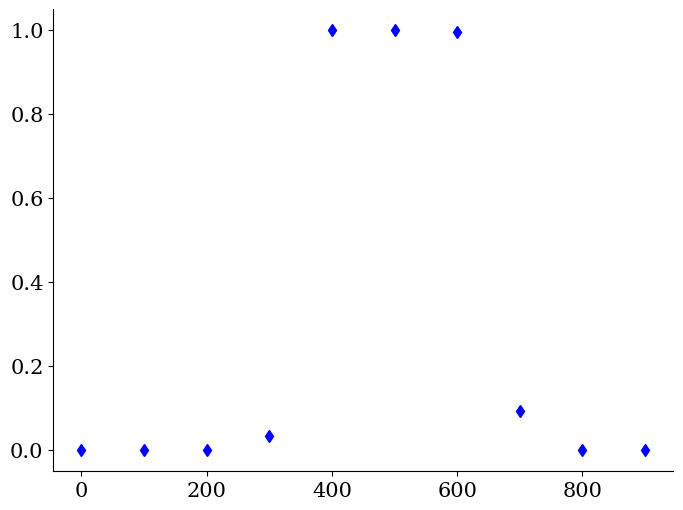

In [71]:
a = np.zeros(10)
for i in range(0,10):
    a[i] = operate(i*100)[-1]
    plt.plot(i*100,a[i],marker='d',ls='',color='b')

In [72]:
K_aa = A[0:-1,0:-1]
K_ab = A[:-1, -1].reshape(-1, 1)
K_ba = A[-1, :-1].reshape(1, -1)
K_bb = A[-1,-1].reshape(1,1)
c_a = c0[0:-1]
c_b = c0[-1]

In [73]:
def operate_reduced(n):
    c_rest = np.copy(c_a)
    K_aa_inv = np.linalg.inv(K_aa)
    K_eff = K_bb + K_ba@K_aa_inv@K_ab
    K_eff_inv = np.linalg.inv(K_eff)
    cn = np.copy(c_b)
    for i in range(n):
        ceff = cn - K_ba@K_aa_inv@c_rest
        cn = K_eff_inv@ceff
        c_rest = K_aa_inv@(c_rest - K_ab@cn)
    return cn

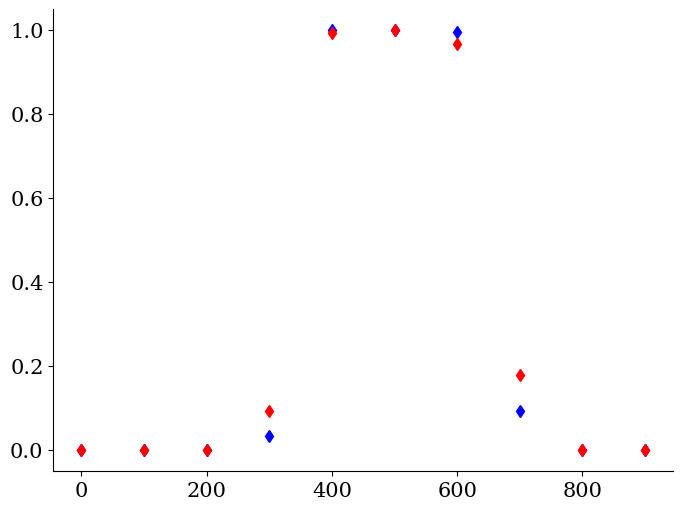

In [74]:
b = np.zeros(10)
for i in range(0,10):
    b[i] = operate_reduced(i*100)
    plt.plot(i*100,a[i],marker='d',ls='',color='b')
    plt.plot(i*100,b[i],marker='d',ls='',color='r')

Abweichungen implizit durch time stepping (LHS zu RHS).

In [75]:
A2 = I + v*dt*0.1/dx*(I-np.diag([1]*(len(x)-1),-1))

In [76]:
K_aa = A2[0:-1,0:-1]
K_ab = A2[:-1, -1].reshape(-1, 1)
K_ba = A2[-1, :-1].reshape(1, -1)
K_bb = A2[-1,-1].reshape(1,1)
c_a = c0[0:-1]
c_b = c0[-1]

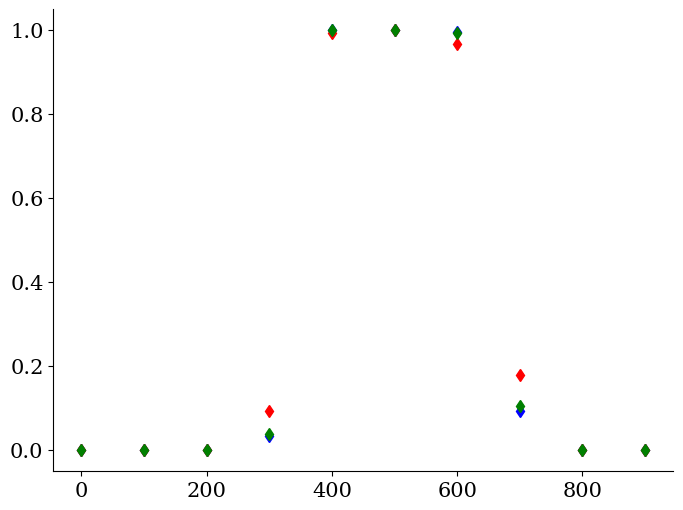

In [79]:
c = np.zeros(10)
for i in range(0,10):
    c[i] = operate_reduced(i*1000)
    plt.plot(i*100,a[i],marker='d',ls='',color='b')
    plt.plot(i*100,b[i],marker='d',ls='',color='r')
    plt.plot(i*100,c[i],marker='d',ls='',color='g')